## **TF-IDF**

---
## Step 1 — Load a small 20 Newsgroups subset and inspect it

We will load three concise categories from scikit-learn's 20 Newsgroups dataset for fast experiments.  
This cell loads the training split for those categories, prints the number of documents and categories, shows how many documents per category, and prints short snippets from the first few documents so you can see the raw text we'll work with.

---

In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# choose categories
categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics']

# load dataset
newsgroups = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

texts = newsgroups.data
targets = newsgroups.target
target_names = newsgroups.target_names

# build a dataframe properly
df = pd.DataFrame({
    "text": texts,
    "target_id": targets,
    "target_name": [target_names[i] for i in targets]
})

print("Loaded categories:", target_names)
print("Number of documents:", len(texts))

# count documents per category
counts = df["target_name"].value_counts()
print("\nDocuments per category:")
print(counts)

df.head()


Loaded categories: ['comp.graphics', 'rec.sport.baseball', 'sci.space']
Number of documents: 1774

Documents per category:
target_name
rec.sport.baseball    597
sci.space             593
comp.graphics         584
Name: count, dtype: int64


,text,target_id,target_name
0,\nBy '8 grey level images' you mean 8 items of...,0,comp.graphics
1,\nThere was a very useful article in one of th...,0,comp.graphics
2,"Bunker & McNally were later.\n\nPappas, Estrad...",1,rec.sport.baseball
3,"\nCalled ""gas"".\n\n\nThe balloons were in suff...",2,sci.space
4,\nBut you still need the pitching staff to hol...,1,rec.sport.baseball


---
## Step 2 — Build TF–IDF, inspect vocabulary, and examine one document's TF–IDF weights

### What this step does  
We create a `TfidfVectorizer` and fit it to our dataset.  
This converts every document into a TF–IDF vector based on word importance.

### Why these parameters are chosen  
- `lowercase=True`  
  Ensures consistent matching of words by converting everything to lowercase.

- `stop_words='english'`  
  Removes extremely common English words (like “the”, “and”) that carry little meaning and would dominate the vectors.

- `max_df=0.9`  
  Ignores words that appear in more than 90% of documents.  
  Such words are too common to be useful for distinguishing documents.

- `min_df=2`  
  Keeps only words that appear in at least 2 documents.  
  Extremely rare words often add noise and inflate vocabulary size.

### What we output  
1. The total vocabulary size after filtering.  
2. The TF–IDF weights of one document.  
3. The **top 10 highest-weight tokens** for that document, showing what the model thinks is most important.

---

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(lowercase=True, stop_words= "english",
                             max_df= 0.9, min_df = 2, )
#print(vectorizer.get_stop_words())

tfidf_matrix = vectorizer.fit_transform(texts)
vocab = vectorizer.get_feature_names_out()
#print(vocab)

print("Vocabulary size:", len(vocab))
#print(tfidf_matrix)

Vocabulary size: 10416


In [27]:
doc_index = 5 # lets inspect for the sixth document in our dataset
doc_vector = tfidf_matrix[doc_index]
nonzero_indices = doc_vector.indices
nonzero_data = doc_vector.data


doc_df = pd.DataFrame({
    "token": vocab[nonzero_indices],
    "tfidf": nonzero_data
}).sort_values("tfidf", ascending=False).reset_index(drop=True)

print(f"{doc_index}'th document with topic {df.target_name[doc_index]} has the following top 5 frequent words:")
doc_df.head()


5'th document with topic rec.sport.baseball has the following top 5 frequent words:


,token,tfidf
0,win,0.382816
1,games,0.214376
2,essentially,0.193526
3,year,0.167878
4,pitching,0.162579


---
## Step 3 — Compute cosine similarity between a query and all documents

### Goal of this step  
We want to see how TF–IDF is actually *used* to find relevant documents.  
We will take a short text query, transform it into a TF–IDF vector using the **same vectorizer**, and compute cosine similarity with every document.

This shows how IR systems rank documents based on vector similarity.

### Why cosine similarity?  
- TF–IDF vectors vary in length (different document sizes).  
- Cosine similarity compares only the **angle** between vectors, not their magnitude.  
- This makes similarity robust and widely used in IR systems.

### What this cell does  
1. Define a **sample query** such as `"space shuttle mission"`.  
2. Convert it to a TF–IDF vector.  
3. Compute cosine similarity between the query and all documents.  
4. Rank the top 5 most relevant documents.  
5. Print their category + a snippet so you can see *why* they matched.

After this step, we will visually inspect how well TF–IDF retrieves meaningful documents.

---

### What is the query vector?

The **query vector** is the TF–IDF representation of the user's search query.  
We take the raw text query (e.g., `"space shuttle mission"`) and apply the **same trained TF–IDF vectorizer** that was fitted on the document corpus.

This converts the query into a numerical vector with the same dimensions as the document TF–IDF matrix.  
Each dimension represents a word in the vocabulary, and its value reflects how important that word is in the query relative to the whole dataset.

This allows us to directly compare the query to every document using cosine similarity.

---

In [38]:
query = ["Space shuttle mission"]
query_vector = vectorizer.transform(query)
indices = query_vector.nonzero()[1]
values = query_vector.data  # actual tf-idf values

for idx, val in zip(indices, values):
    print(f"Token '{vocab[idx]}' has TF-IDF weight {val}")
#print(query_vector.toarray()[0][indices])


Token 'mission' has TF-IDF weight 0.6652845186983247
Token 'shuttle' has TF-IDF weight 0.6100211130597171
Token 'space' has TF-IDF weight 0.43043088969278487


In [61]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
top_indices = np.argsort(similarities)[::-1][:5] # sorting descending top 5

print("Query:", query[0])
print("\nTop 5 most similar documents:\n")

for rank, idx in enumerate(top_indices, start=1):
    snippet = texts[idx].strip().replace("\n", " ")
    if len(snippet) > 300:
        snippet = snippet[:300] + "..."
    print(f"Rank {rank} | Document index {idx} | Similarity: {similarities[idx]:.4f} | Category: {target_names[targets[idx]]}")
    print(snippet)
    print("-"*1000)


Query: Space shuttle mission

Top 5 most similar documents:

Rank 1 | Document index 1760 | Similarity: 0.3882 | Category: sci.space
Ed Campion Headquarters, Washington, D.C.                             April 23, 1993 (Phone:  202/358-1780)  Kyle Herring Johnson Space Center, Houston (Phone:  713/483-5111)  RELEASE:  93-76  HUBBLE TELESCOPE SERVICING MISSION SCHEDULED FOR ELEVEN DAYS  	The December flight of Endeavour on Space Sh...
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
## Step 4 — Visualize TF–IDF document vectors using PCA

### Goal of this step  
We want to *see* how TF–IDF separates documents from different categories.  
Because TF–IDF vectors are high-dimensional (thousands of features), we reduce them to **2 dimensions** using PCA so we can plot them.

### Why PCA?  
- It is a linear dimensionality-reduction method.  
- Fast and suitable for sparse TF–IDF matrices.  
- Helps us visually inspect whether categories form clusters.

### What this cell does  
1. Applies PCA to reduce all TF–IDF vectors to 2D.  
2. Plots them as a scatter plot.  
3. Colors each point by its category (space, baseball, graphics).  
4. Helps you visually understand how TF–IDF groups similar documents.

---

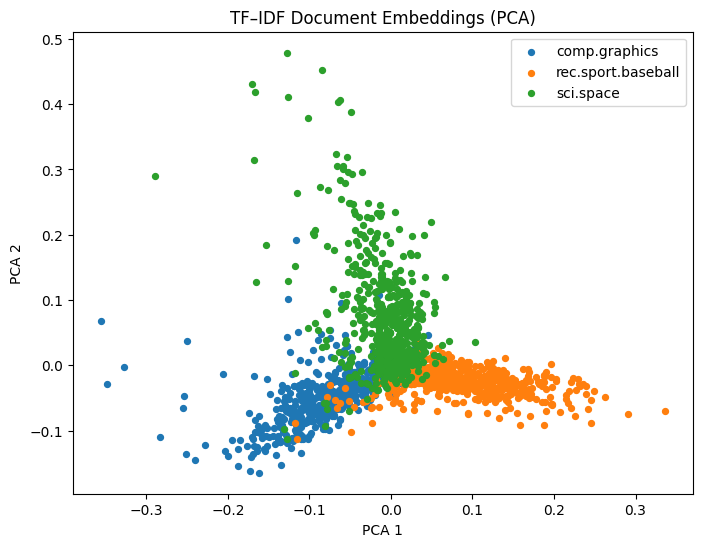

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())


plt.figure(figsize=(8,6))

for i, name in enumerate(target_names):
    points = reduced[np.array(targets) == i]
    plt.scatter(points[:,0], points[:,1], label=name, s=18)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("TF–IDF Document Embeddings (PCA)")
plt.legend()
plt.show()


---

## Step 5 — Compare `CountVectorizer` (raw counts) vs `TfidfVectorizer` (TF–IDF) for the same query

### What this step does  
We build a `CountVectorizer` with the same preprocessing choices as the TF–IDF vectorizer and compare how each method ranks documents for the same query. This highlights the practical effect of IDF weighting: TF–IDF downweights very common terms across the corpus and upweights distinctive terms, which can change ranking order.

### Why compare these two
- `CountVectorizer` represents documents by raw token counts; it treats all terms equally regardless of global rarity.  
- `TfidfVectorizer` accounts for a term’s rarity across documents (the IDF part) so rare-but-informative words get more weight.  
- Observing differences for the same query shows when IDF helps (e.g., when common words would otherwise dominate) and when raw counts might still be useful.

### Parameters chosen and why
- `lowercase=True` and `stop_words='english'` to match preprocessing used earlier and ensure a fair comparison.  
- `max_df=0.9` and `min_df=2` to ignore extremely common and extremely rare terms, keeping the vocabulary manageable and comparable to the TF–IDF run.

---

## **Inverted Index**

---

# Inverted Index — Step 1: Prepare corpus and build a simple inverted index

What this step does
1. Load the same 20 Newsgroups subset (three categories) so experiments stay consistent.  
2. Tokenize each document into normalized word tokens and remove English stop words.  
3. Build an inverted index mapping `term -> postings list` where each posting is `(doc_id, [positions])`.  
4. Compute document frequencies and document-length statistics.  
5. Print dataset stats, the top-10 most document-frequent terms, and example postings for inspection.

Why these choices
- Tokenization with `\w+` is simple and interpretable for a learning notebook.  
- Lowercasing ensures tokens match regardless of capitalization.  
- Removing English stop words keeps the index focused on informative terms.  
- Storing positions enables phrase and proximity queries later.  
- Document IDs are the Python default (starting at 0) unless you request a different convention.

What you should check in the output
- Number of documents and vocabulary size to confirm the corpus loaded correctly.  
- Document length stats to understand corpus variability (useful later for BM25).  
- Top terms by document frequency to verify that common tokens were retained/filtered as expected.  
- Postings format `(doc_id, [positions])` to ensure positions were recorded correctly.

---

In [84]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from collections import defaultdict, Counter
import pandas as pd

categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics']
raw = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers','quotes'))
docs = raw.data

token_pattern = re.compile(r"\w+")
stop_words = set(ENGLISH_STOP_WORDS)

inverted_index = defaultdict(list)
doc_freq = Counter()
doc_lengths = {}

for doc_id, text in enumerate(docs):
    tokens = [t.lower() for t in token_pattern.findall(text)]
    tokens = [t for t in tokens if t not in stop_words]
    doc_lengths[doc_id] = len(tokens)
    positions_by_term = defaultdict(list)
    for pos, tok in enumerate(tokens):
        positions_by_term[tok].append(pos)
    for term, positions in positions_by_term.items():
        inverted_index[term].append((doc_id, positions))
    for term in positions_by_term.keys():
        doc_freq[term] += 1

vocab_size = len(inverted_index)
num_docs = len(docs)

print("Number of documents:", num_docs)
print("Vocabulary size (after stop-word removal):", vocab_size)

lengths = list(doc_lengths.values())
print("\nDocument length stats:")
print(pd.Series(lengths).describe()[["min","50%","mean","max"]])

most_common_terms = doc_freq.most_common(10)
print("\nTop 10 terms by document frequency:")
for term, df in most_common_terms:
    print(f"{term} — df={df}")

examples = [most_common_terms[0][0], most_common_terms[3][0]]
print("\nExample postings lists (first 10 postings shown for each term):")
for term in examples:
    postings = inverted_index[term][:10]
    print(f"\nTerm: '{term}' | df={doc_freq[term]}")
    print(postings)


Number of documents: 1774
Vocabulary size (after stop-word removal): 22383

Document length stats:
min        0.000000
50%       35.000000
mean      97.421646
max     6990.000000
dtype: float64

Top 10 terms by document frequency:
s — df=670
t — df=620
like — df=379
just — df=338
know — df=320
don — df=311
think — df=299
1 — df=293
m — df=293
2 — df=280

Example postings lists (first 10 postings shown for each term):

Term: 's' | df=670
[(0, [42]), (6, [1, 9]), (13, [7, 53, 73]), (17, [49, 83]), (18, [0]), (20, [4, 13]), (23, [17]), (25, [14]), (27, [64, 105, 118, 140]), (28, [5])]

Term: 'just' | df=338
[(27, [89]), (34, [3159]), (44, [160]), (47, [20]), (48, [104]), (49, [0]), (51, [4]), (52, [2, 19]), (54, [41]), (64, [13])]


### Quick checks and examples

Below you will see:
- The 10 most document-frequent tokens (terms that appear in the most documents) and their document frequencies.  
- Example postings lists for two informative tokens to inspect the stored `(doc_id, positions)` structure.  
This helps confirm the index is built correctly and shows how postings store both which documents contain a term and where that term occurs inside the document.


In [83]:
most_common_terms = doc_freq.most_common(10)
print("Top 10 terms by document frequency:\n")
for term, df in most_common_terms:
    print(f"{term} — df={df}")

examples = [most_common_terms[0][0], most_common_terms[3][0]]
print("\n\nExample postings lists:\n")
for term in examples:
    postings = inverted_index[term][:10]
    print(f"Term: '{term}' | df={doc_freq[term]} | first 10 postings (doc_id, positions):")
    print(postings)
    print()


Top 10 terms by document frequency:

s — df=670
t — df=620
like — df=379
just — df=338
know — df=320
don — df=311
think — df=299
1 — df=293
m — df=293
2 — df=280


Example postings lists:

Term: 's' | df=670 | first 10 postings (doc_id, positions):
[(1, [42]), (7, [1, 9]), (14, [7, 53, 73]), (18, [49, 83]), (19, [0]), (21, [4, 13]), (24, [17]), (26, [14]), (28, [64, 105, 118, 140]), (29, [5])]

Term: 'just' | df=338 | first 10 postings (doc_id, positions):
[(28, [89]), (35, [3159]), (45, [160]), (48, [20]), (49, [104]), (50, [0]), (52, [4]), (53, [2, 19]), (55, [41]), (65, [13])]



---

### How to read and interpret the output of Step 1

When you run Step 1, you’ll see several kinds of information.  
Here is how to understand each part of the printed output:

---



## 1. **"Number of documents: X"**
This tells you how many documents from the selected 20 Newsgroups categories are loaded.  
These are the documents we build the inverted index over.

---

## 2. **"Vocabulary size: Y"**
This is the total number of **unique terms** that survived:  
- tokenization  
- lowercasing  
- stop-word removal  
- min_df=1 (every remaining word appeared at least once somewhere)

This number is usually in the thousands: that’s your **index vocabulary**.

---

## 3. **Document length statistics**
You will see:  
- **min**: shortest document (after removing stop words)  
- **50% (median)**: typical document length  
- **mean**: average length  
- **max**: longest document  

These lengths matter later for ranking functions (BM25, etc.).

---

## 4. **Top 10 terms by document frequency**
Output looks like:

term — df=42
graphics — df=35
game — df=30
..


- **df (document frequency)** = number of documents that contain this term.  
- High-df terms are common across many documents.  
- These are often topic-general words (like "game", "team", "graphics").

This helps verify the index is correct and gives a sense of which concepts dominate the dataset.

---

## 5. **Example postings lists**
You’ll see something like:

Term: 'game' | df=30 | first 10 postings (doc_id, positions):
[(3, [5, 17]), (7, [8]), (12, [1, 9, 16]), ...]

This is the heart of the inverted index.

Each entry `(doc_id, positions)` means:

- **doc_id** — which document contains the term  
- **positions** — the word positions where that term appears in that document  
  (position 0 = first token after preprocessing)

Example interpretation:

`(12, [1, 9, 16])` means  
- Term appears **in document 12**  
- At token positions **1, 9, and 16** within that document

This is precisely the structure search engines use for:  
- Boolean queries  
- Phrase search ("space shuttle mission")  
- Proximity queries  
- Ranking and scoring later

---


## **evaluation**

# Evaluation Step 1 — Load train/test datasets and build the train index & TF–IDF

### What this step does
1. Load the 20 Newsgroups dataset using **train split** for building all retrieval models.  
2. Load the **test split** which will supply our evaluation queries.  
3. From the train set:
   - Tokenize documents  
   - Remove English stop words  
   - Build an inverted index mapping:  
     `term → list of (doc_id_train, [positions])`  
   - Save document lengths and document frequencies  
4. Build the **TF–IDF vectorizer** and matrix on the train documents only.  

### Why this is the correct approach
- Retrieval systems are trained/indexed on a fixed corpus (train).  
- Queries come from unseen data (test).  
- Relevance is defined by category labels:  
  documents in the train corpus with the same category as the test query document.

### Outputs of this step
- `train_docs`, `test_docs`  
- `inverted_index`  
- `tfidf_matrix` and `vectorizer`  
- Train document frequencies, document lengths  
- Ready for query generation and evaluation in the next step.

---

In [89]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import defaultdict, Counter
import pandas as pd
import numpy as np

categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers','quotes'))
test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers','footers','quotes'))

train_docs = train.data
train_targets = train.target
test_docs = test.data
test_targets = test.target
target_names = train.target_names

token_pattern = re.compile(r"\w+")
stop_words = set(ENGLISH_STOP_WORDS)

inverted_index = defaultdict(list)
train_doc_freq = Counter()
train_doc_lengths = {}
num_train_docs = len(train_docs)

for doc_id, text in enumerate(train_docs):
    tokens = [t.lower() for t in token_pattern.findall(text)]
    tokens = [t for t in tokens if t not in stop_words]
    train_doc_lengths[doc_id] = len(tokens)
    positions_by_term = defaultdict(list)
    for pos, tok in enumerate(tokens):
        positions_by_term[tok].append(pos)
    for term, positions in positions_by_term.items():
        inverted_index[term].append((doc_id, positions))
    for term in positions_by_term.keys():
        train_doc_freq[term] += 1

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.9, min_df=2)
tfidf_matrix = vectorizer.fit_transform(train_docs)

print("Train docs:", len(train_docs), "Test docs:", len(test_docs))
print("Train vocabulary size:", len(vectorizer.get_feature_names_out()))
print("Train document length stats:")
print(pd.Series(list(train_doc_lengths.values())).describe()[["min","50%","mean","max"]])


Train docs: 1774 Test docs: 1180
Train vocabulary size: 10416
Train document length stats:
min        0.000000
50%       35.000000
mean      97.421646
max     6990.000000
dtype: float64


---

Step 2: Create test queries from the test split

What this cell does
1. For each selected test document we produce a short query formed by the top-k TF–IDF tokens where TF–IDF is computed by applying the train-fit vectorizer to the test document.  
2. We sample a reproducible subset of test documents as queries (fixed random seed).  
3. Each query record contains: `qid` (test doc index), `query_text`, `query_terms`, and `relevant_label` (test doc category).

Why this approach
- Using top TF–IDF tokens from test documents yields concise, realistic queries that a retriever should answer.
- Using a random but seeded subset keeps evaluation quick and reproducible.

Outputs
- `queries` list with structured query info for evaluation.

---

In [90]:
import random
np.random.seed(42)
random.seed(42)

num_queries = 100
num_test_docs = len(test_docs)
if num_queries > num_test_docs:
    num_queries = num_test_docs

query_indices = random.sample(list(range(num_test_docs)), num_queries)
top_k_terms = 5

test_tfidf = vectorizer.transform(test_docs)

def top_k_terms_from_vector(row_vec, k=top_k_terms):
    arr = row_vec.toarray().flatten()
    nz = np.where(arr > 0)[0]
    if len(nz) == 0:
        return []
    top_idx = nz[np.argsort(arr[nz])][::-1][:k]
    features = vectorizer.get_feature_names_out()
    return [features[i] for i in top_idx]

queries = []
for qi in query_indices:
    row = test_tfidf[qi]
    terms = top_k_terms_from_vector(row, top_k_terms)
    query_text = " ".join(terms) if terms else " ".join(token_pattern.findall(test_docs[qi])[:top_k_terms])
    queries.append({
        "qid": qi,
        "query_text": query_text,
        "query_terms": terms,
        "relevant_label": test_targets[qi]
    })

print("Prepared queries:", len(queries))
print("Example query:", queries[0])


Prepared queries: 100
Example query: {'qid': 228, 'query_text': 'library windows exhibit viewers connection', 'query_terms': ['library', 'windows', 'exhibit', 'viewers', 'connection'], 'relevant_label': np.int64(0)}


---
#Step 3: Helper functions for ranking and textbook metrics

What this cell does
1. Implements retrievers:
   - TF–IDF cosine ranking using the train TF–IDF matrix and train vectorizer.  
   - Term-overlap baseline that counts how many query terms occur in each train doc using the inverted index.
2. Implements metrics:
   - precision@r and recall@r arrays along a full ranked list,
   - Average Precision (AP) per textbook (mean of precision at ranks with relevant docs),
   - 11-point interpolated precision (recall levels 0.0,0.1,...,1.0) per query.

Why these implementations
- These functions directly map to the textbook evaluation procedures so results are comparable to chapter descriptions.

---

In [91]:
from sklearn.metrics.pairwise import cosine_similarity

def rank_tfidf_cosine(query_text):
    qv = vectorizer.transform([query_text])
    sims = cosine_similarity(qv, tfidf_matrix).flatten()
    ranked_indices = np.argsort(sims)[::-1]
    ranked_scores = sims[ranked_indices]
    return ranked_indices, ranked_scores

def rank_term_overlap(query_terms):
    counts = np.zeros(num_train_docs, dtype=int)
    for t in query_terms:
        postings = inverted_index.get(t, [])
        for doc_id, _ in postings:
            counts[doc_id] += 1
    ranked_indices = np.argsort(counts)[::-1]
    ranked_scores = counts[ranked_indices].astype(float)
    return ranked_indices, ranked_scores

def precision_recall_at_ranks(ranked_indices, relevant_set):
    relevant_flags = np.array([1 if doc in relevant_set else 0 for doc in ranked_indices], dtype=int)
    cum_relevant = np.cumsum(relevant_flags)
    ranks = np.arange(1, len(ranked_indices) + 1)
    precision_at_r = cum_relevant / ranks
    total_relevant = len(relevant_set)
    if total_relevant == 0:
        recall_at_r = np.zeros_like(precision_at_r)
    else:
        recall_at_r = cum_relevant / total_relevant
    return precision_at_r, recall_at_r, relevant_flags

def average_precision(precision_at_r, relevant_flags):
    relevant_positions = np.where(relevant_flags == 1)[0]
    if relevant_positions.size == 0:
        return 0.0
    precisions_at_relevant = precision_at_r[relevant_positions]
    ap = precisions_at_relevant.mean()
    return ap

def eleven_point_interpolated_precision(precision_at_r, recall_at_r):
    recall_levels = np.linspace(0.0, 1.0, 11)
    interp = []
    for r in recall_levels:
        mask = recall_at_r >= r - 1e-12
        if mask.any():
            interp.append(np.max(precision_at_r[mask]))
        else:
            interp.append(0.0)
    return np.array(interp), recall_levels


---

#Step 4: Run evaluation over all test queries (TF–IDF vs term-overlap)

What this cell does
1. For each test query:
   - Finds the set of relevant train documents (same category label as test query).  
   - Computes TF–IDF ranking and term-overlap ranking.  
   - Computes precision@r, recall@r, AP, and 11-point interpolated precision for each method.
2. Aggregates:
   - Per-query AP arrays for MAP calculation.  
   - Per-query 11-point arrays for averaged interpolated precision curves.

Notes
- Query document itself is in the test split and is not part of the train corpus, so no need to exclude it from the relevant set.

---


In [92]:
tfidf_APs = []
overlap_APs = []
tfidf_interps = []
overlap_interps = []

for q in queries:
    qid = q["qid"]
    qtext = q["query_text"]
    qterms = q["query_terms"]
    rel_label = q["relevant_label"]
    relevant_docs = set([i for i, lbl in enumerate(train_targets) if lbl == rel_label])
    ranked_tfidf, _ = rank_tfidf_cosine(qtext)
    p_tfidf, r_tfidf, flags_tfidf = precision_recall_at_ranks(ranked_tfidf, relevant_docs)
    ap_tfidf = average_precision(p_tfidf, flags_tfidf)
    interp_tfidf, recall_levels = eleven_point_interpolated_precision(p_tfidf, r_tfidf)
    tfidf_APs.append(ap_tfidf)
    tfidf_interps.append(interp_tfidf)
    ranked_ov, _ = rank_term_overlap(qterms)
    p_ov, r_ov, flags_ov = precision_recall_at_ranks(ranked_ov, relevant_docs)
    ap_ov = average_precision(p_ov, flags_ov)
    interp_ov, _ = eleven_point_interpolated_precision(p_ov, r_ov)
    overlap_APs.append(ap_ov)
    overlap_interps.append(interp_ov)

tfidf_MAP = float(np.mean(tfidf_APs))
overlap_MAP = float(np.mean(overlap_APs))
tfidf_mean_interp = np.mean(np.vstack(tfidf_interps), axis=0)
overlap_mean_interp = np.mean(np.vstack(overlap_interps), axis=0)

print("Evaluated", len(queries), "queries")
print("TF–IDF MAP:", round(tfidf_MAP, 4))
print("Term-overlap MAP:", round(overlap_MAP, 4))


Evaluated 100 queries
TF–IDF MAP: 0.3926
Term-overlap MAP: 0.3894


---
#Step 5: Plot averaged 11-point interpolated precision–recall curves

What this cell does
1. Plots the averaged 11-point interpolated precision values for TF–IDF and term-overlap across the standard recall levels.  
2. Adds MAP values to the legend for quick numeric comparison.

Why this plot
- This plot is the textbook's standard compact way to compare ranked retrieval systems.

---

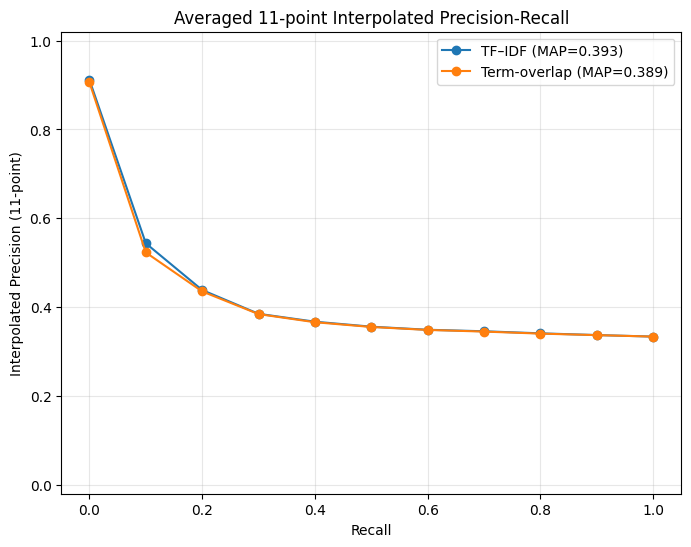

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(recall_levels, tfidf_mean_interp, marker='o', label=f"TF–IDF (MAP={tfidf_MAP:.3f})")
plt.plot(recall_levels, overlap_mean_interp, marker='o', label=f"Term-overlap (MAP={overlap_MAP:.3f})")
plt.xlabel("Recall")
plt.ylabel("Interpolated Precision (11-point)")
plt.title("Averaged 11-point Interpolated Precision-Recall")
plt.ylim(-0.02, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()



---
# Step 6 — Per-query precision–recall plots and summary table

What this cell does
1. Plots precision vs recall for the first six queries for quick inspection.  
2. Displays a summary table with MAP, mean AP, median AP, and std AP for both methods.
---

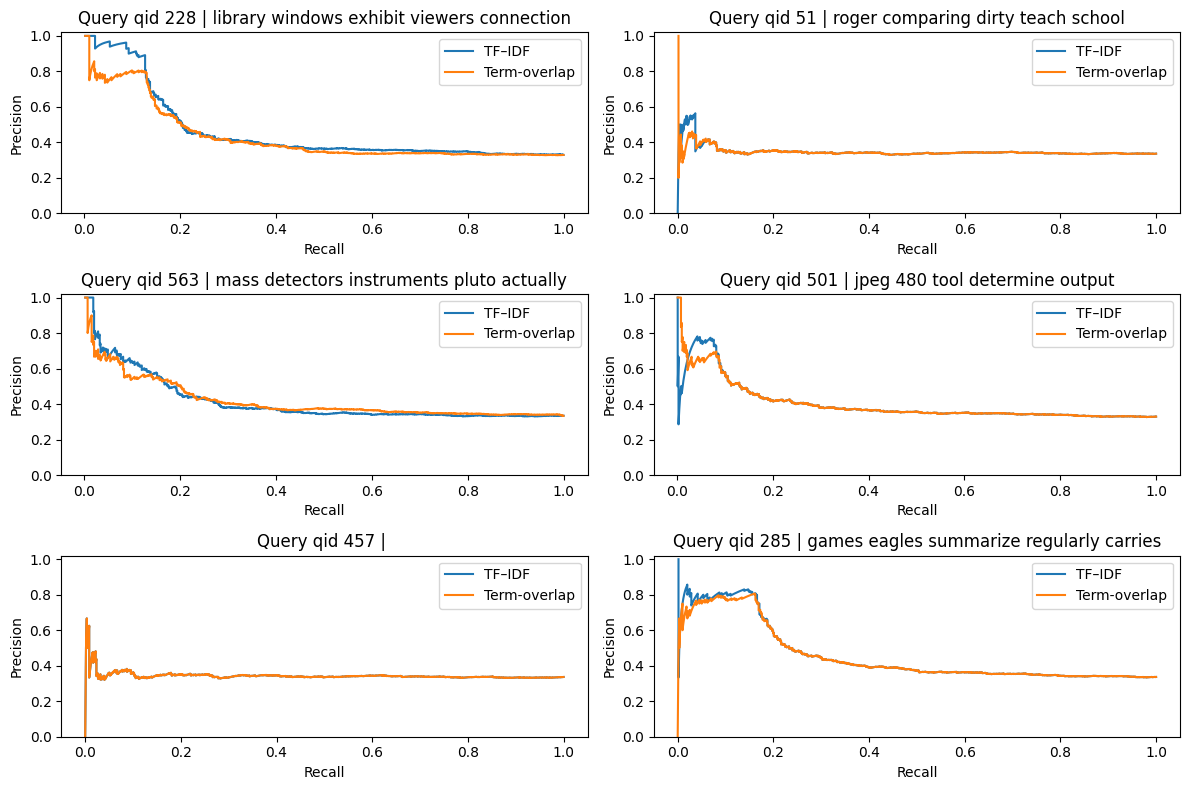

,method,MAP,mean_AP,median_AP,std_AP
0,TF–IDF,0.392584,0.392584,0.370696,0.056890
1,Term-overlap,0.389446,0.389446,0.370758,0.052972


In [94]:
import matplotlib.pyplot as plt
import pandas as pd

example_qs = queries[:6]

plt.figure(figsize=(12,8))
for i, q in enumerate(example_qs, start=1):
    rel_label = q["relevant_label"]
    relevant_docs = set([i for i, lbl in enumerate(train_targets) if lbl == rel_label])
    ranked_tfidf, _ = rank_tfidf_cosine(q["query_text"])
    p_tfidf, r_tfidf, _ = precision_recall_at_ranks(ranked_tfidf, relevant_docs)
    ranked_ov, _ = rank_term_overlap(q["query_terms"])
    p_ov, r_ov, _ = precision_recall_at_ranks(ranked_ov, relevant_docs)
    plt.subplot(3,2,i)
    plt.plot(r_tfidf, p_tfidf, label='TF–IDF')
    plt.plot(r_ov, p_ov, label='Term-overlap')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    title_txt = q["query_text"] if len(q["query_text"]) < 60 else q["query_text"][:57] + "..."
    plt.title(f"Query qid {q['qid']} | {title_txt}")
    plt.legend()
    plt.ylim(0,1.02)
plt.tight_layout()
plt.show()

summary = pd.DataFrame({
    "method": ["TF–IDF", "Term-overlap"],
    "MAP": [tfidf_MAP, overlap_MAP],
    "mean_AP": [float(np.mean(tfidf_APs)), float(np.mean(overlap_APs))],
    "median_AP": [float(np.median(tfidf_APs)), float(np.median(overlap_APs))],
    "std_AP": [float(np.std(tfidf_APs)), float(np.std(overlap_APs))]
})
display(summary)


---
# Step 8 — Precision vs Recall curve for a single query (non-interpolated, with markers and vertical stems)

What this cell does
1. Selects one example test query (the first in `queries`).  
2. Computes the TF–IDF ranked list for that query and the precision and recall at every rank using the textbook definitions.  
3. Plots the **non-interpolated** precision–recall curve with:
   - connected markers (precision points at each rank),
   - light vertical stems from the x-axis up to each precision point (to match the style you provided),
   - axis limits and grid similar to the example figure.

How to read the plot
- Each marker corresponds to a rank in the ranked list; x = recall after that rank, y = precision after that rank.  
- Vertical stems visually emphasize the jumps in precision at the ranks where relevant documents are found.  
- This is the exact per-rank precision/recall behavior the textbook shows (Figure 11.3) and matches the non-interpolated example you provided.

---

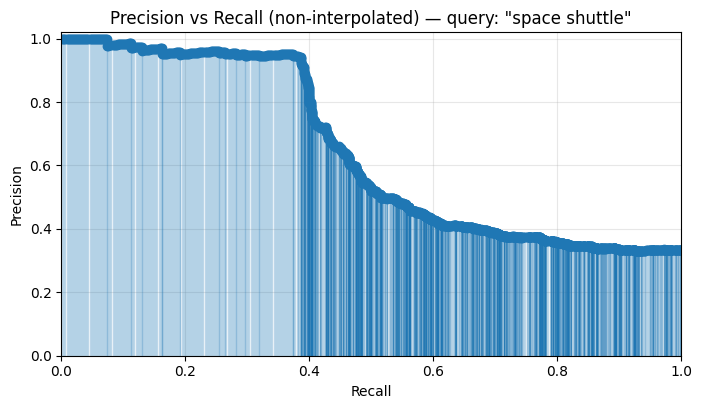

In [96]:
import matplotlib.pyplot as plt
import numpy as np

query_text = "space shuttle"
query_label = target_names.index("sci.space")
relevant_docs = set([i for i, lbl in enumerate(train_targets) if lbl == query_label])

ranked, _ = rank_tfidf_cosine(query_text)
precision_at_r, recall_at_r, _ = precision_recall_at_ranks(ranked, relevant_docs)

xs = recall_at_r
ys = precision_at_r

plt.figure(figsize=(8,4.2))
plt.plot(xs, ys, linestyle='-', marker='o', markersize=6, color='tab:blue')
for x, y in zip(xs, ys):
    plt.vlines(x, 0, y, colors='tab:blue', alpha=0.25, linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision vs Recall (non-interpolated) — query: "space shuttle"')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.02)
plt.grid(alpha=0.3)
plt.show()
